## 1.Explore the YOLO model, understand how it works.

1. Divide the WxH image into  SxS grid
2. For each Grid:
    
    a. Detect B numbers of bounding box that contains an object
    
    b. Predict C condiction probability base on the trained class

Architecture of model:

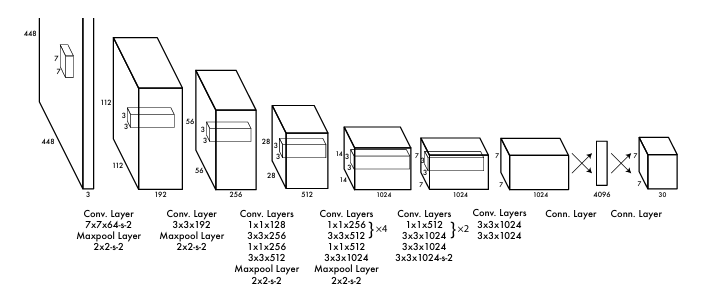

*Redmon, Joseph, Santosh Divvala, Ross Girshick, and Ali Farhadi. "You only look once: 
Unified, real-time object detection." In Proceedings of the IEEE conference on computer 
vision and pattern recognition, pp. 779-788. 2016.*

dataset:

https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/data

## 2. Define your own object detection case. Get hands-on experience by training and testing the model

Detection of construction site worker and their Personal Protective Equipment (PPE) for identification of site safety issues.

In [20]:
# Imports
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

In [21]:
# Define the model
class CNN(nn.Module):
    def __init__(self, classes = 10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(128 * 8 * 8, classes)
       

    def forward(self, x):  # input: batch_size * 3 * 64 * 64
        batch_size = x.shape[0]
        
        x = self.conv1(x) # batch_size * 32 * 64 * 64
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)  # batch_size * 32 * 32 * 32
        
        x = self.conv2(x) # batch_size * 64 * 32 * 32
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)  # batch_size * 64 * 16 * 16
        
        x = self.conv3(x) # batch_size * 128 * 16 * 16
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)  # batch_size * 128 * 8 * 8
        
        x = x.view(batch_size, -1) # batch_size * (128 * 8 * 8)
        x = self.fc1(x)            # batch_size * 10
        
        return x

In [22]:
# Load dataset for object detection (Roboflow YOLO labels)

import os
from glob import glob
from pathlib import Path
from PIL import Image
from typing import List, Dict, Tuple

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms


class YOLODataset(Dataset):
    """
    A Dataset that reads images and Roboflow-exported YOLO label .txt files.
    Assumes directory layout:
      root_dir/
        train|valid|test/
          images/*.jpg|.png|.jpeg
          labels/*.txt  (same stem as image)

    Label file format (per line):
      <class_id> <x_center> <y_center> <width> <height>
    where all bbox coordinates are normalized to [0, 1] relative to image size.
    """

    IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")

    def __init__(self, root_dir: str, split: str = "train", input_size: int = 448, transform=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.images_dir = self.root_dir / split / "images"
        self.labels_dir = self.root_dir / split / "labels"
        self.input_size = input_size

        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((input_size, input_size)),
                transforms.ToTensor(),
            ])
        else:
            self.transform = transform

        # Gather image files
        self.image_paths = []
        for ext in self.IMG_EXTS:
            self.image_paths.extend(sorted(self.images_dir.glob(f"*{ext}")))

        if len(self.image_paths) == 0:
            raise FileNotFoundError(f"No images found in {self.images_dir}")

    def __len__(self) -> int:
        return len(self.image_paths)

    def _read_labels(self, label_path: Path) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Read YOLO txt label file. Returns (labels, boxes) where:
          - labels: (N,) int64 tensor of class ids
          - boxes: (N, 4) float32 tensor of [x_center, y_center, width, height] normalized to [0,1]
        If no file or empty, returns empty tensors with right shapes.
        """
        if not label_path.exists():
            return torch.zeros((0,), dtype=torch.long), torch.zeros((0, 4), dtype=torch.float32)

        labels: List[int] = []
        boxes: List[List[float]] = []
        with open(label_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split()
                if len(parts) != 5:
                    # Skip malformed lines safely
                    continue
                cls_id, x_c, y_c, w, h = parts
                try:
                    labels.append(int(float(cls_id)))
                    boxes.append([float(x_c), float(y_c), float(w), float(h)])
                except ValueError:
                    # Skip rows with invalid numbers
                    continue

        if len(labels) == 0:
            return torch.zeros((0,), dtype=torch.long), torch.zeros((0, 4), dtype=torch.float32)

        return torch.tensor(labels, dtype=torch.long), torch.tensor(boxes, dtype=torch.float32)

    def __getitem__(self, idx: int):
        img_path: Path = self.image_paths[idx]
        label_path = self.labels_dir / (img_path.stem + ".txt")

        # Load image
        with Image.open(img_path) as img:
            img = img.convert("RGB")
            img = self.transform(img)

        # Load labels (normalized YOLO format)
        labels, boxes = self._read_labels(label_path)

        # Build target dictionary commonly used for detection
        target: Dict[str, torch.Tensor] = {
            "labels": labels,          # (N,)
            "boxes_yolo": boxes,       # (N, 4) normalized [x_c, y_c, w, h]
            "image_id": torch.tensor([idx], dtype=torch.int64),
            "orig_path": str(img_path),
        }

        return img, target


def detection_collate_fn(batch):
    """Custom collate to handle variable number of boxes per image."""
    images = [b[0] for b in batch]
    targets = [b[1] for b in batch]
    return torch.stack(images, dim=0), targets


def load_yolo_data(data_dir: str = "./data/", input_size: int = 448, batch_size: int = 16):
    """
    Create DataLoaders for object detection using Roboflow YOLO labels.
    Expects the following structure under data_dir:
      data_dir/
        train/ images/, labels/
        valid/ images/, labels/
        test/  images/, labels/    (optional)
    """
    train_ds = YOLODataset(data_dir, split="train", input_size=input_size)
    valid_split = "valid" if (Path(data_dir) / "valid").exists() else "test"
    valid_ds = YOLODataset(data_dir, split=valid_split, input_size=input_size)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0, collate_fn=detection_collate_fn)
    valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=detection_collate_fn)

    return train_loader, valid_loader

In [23]:
## Note that: here we provide a basic solution for training and validation.
## You can directly change it if you find something wrong or not good enough.

def train_model(model,train_loader, valid_loader, criterion, optimizer, device, num_epochs=20):        
    """
    Trains a classification model. If the loaders come from a detection dataset
    (where the second item is a list of target dicts), it derives a single
    pseudo-label per image from the first box's class id (or 0 if no boxes).
    """
    best_acc = 0.0

    def targets_to_labels(targets):
        """Convert a batch of detection targets (list of dicts) to class indices tensor."""
        cls_ids = []
        for t in targets:
            labs = t.get('labels', None) if isinstance(t, dict) else None
            if labs is None or len(labs) == 0:
                cls_ids.append(0)
            else:
                cls_ids.append(int(labs[0].item()))
        return torch.tensor(cls_ids, dtype=torch.long, device=device)
    
    for epoch in range(num_epochs):
        # train the model
        model.train(True)
        total_loss = 0.0
        total_correct = 0
        for inputs, labels in train_loader:
            # send the data to device (GPU)
            inputs = inputs.to(device)
            # Handle detection-style targets (list of dicts) vs. classification tensors
            if isinstance(labels, list):
                labels_tensor = targets_to_labels(labels)
            else:
                labels_tensor = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs) # prediction
            loss = criterion(outputs, labels_tensor) # loss
            _, predictions = torch.max(outputs, 1) # The class with maximal probability
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_correct += torch.sum(predictions == labels_tensor.data)
        train_loss = total_loss / len(train_loader.dataset)
        train_acc = total_correct.double() / len(train_loader.dataset)
        
        # validation
        model.train(False)
        total_loss = 0.0
        total_correct = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs = inputs.to(device)
                if isinstance(labels, list):
                    labels_tensor = targets_to_labels(labels)
                else:
                    labels_tensor = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels_tensor)
                _, predictions = torch.max(outputs, 1)
                total_loss += loss.item() * inputs.size(0)
                total_correct += torch.sum(predictions == labels_tensor.data)
        valid_loss = total_loss / len(valid_loader.dataset)
        valid_acc = total_correct.double() / len(valid_loader.dataset)
        
        # Show the results
        print('*' * 100)
        print('epoch:{:d}/{:d}'.format(epoch, num_epochs))
        print("training: loss:   {:.4f}, accuracy: {:.4f}".format(train_loss, train_acc))
        print("validation: loss: {:.4f}, accuracy: {:.4f}".format(valid_loss, valid_acc))
        
        # save the best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            best_model = model
            torch.save(best_model, 'best_model.pt')

In [24]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_random_from_loader(loader, class_names=None):
    """
    Visualize a random image from a detection DataLoader created by load_data().
    Draws YOLO-format boxes (normalized) on the resized image.
    """
    imgs, targets = next(iter(loader))  # imgs: (B,3,H,W), targets: list of dicts length B
    b = imgs.shape[0]
    idx = random.randrange(b)

    img = imgs[idx]
    H, W = img.shape[1], img.shape[2]
    target = targets[idx]
    boxes = target.get('boxes_yolo')
    labels = target.get('labels')

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img.permute(1, 2, 0).numpy())

    if boxes is not None and len(boxes) > 0:
        for j, box in enumerate(boxes):
            xc, yc, w, h = box.tolist()
            x1 = (xc - w/2) * W
            y1 = (yc - h/2) * H
            rect = patches.Rectangle((x1, y1), w*W, h*H, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            cls_id = int(labels[j].item()) if labels is not None and j < len(labels) else -1
            cls_txt = (class_names[cls_id] if class_names and 0 <= cls_id < len(class_names) else f"cls {cls_id}")
            ax.text(x1, max(0, y1-3), cls_txt, color='yellow', fontsize=10,
                    bbox=dict(facecolor='black', alpha=0.5, pad=1))
    else:
        ax.text(5, 15, "No labels", color='red', fontsize=12,
                bbox=dict(facecolor='white', alpha=0.7, pad=2))

    ax.axis('off')
    plt.show()


device: cuda


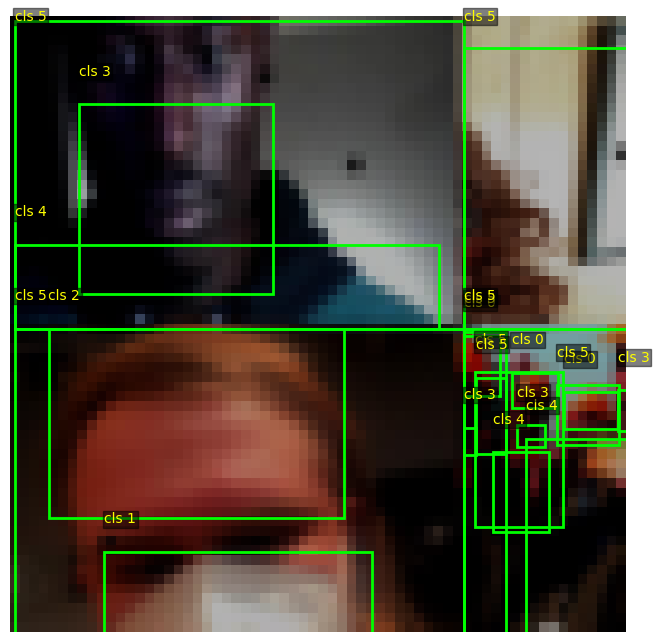

In [25]:
## about model
num_classes = 10

## about data
data_dir = r"./source/css-data/" ## You may need to specify the data_dir first
input_size = 64
batch_size = 64

## about training
num_epochs = 50
lr = 0.001

## model initialization
model = CNN(classes = num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)
model = model.to(device)

## optimizer
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
## loss function
criterion = nn.CrossEntropyLoss()

## detection data preparation for visualization only
yolo_train_loader, yolo_valid_loader = load_yolo_data(data_dir=data_dir, input_size=input_size, batch_size=8)
visualize_random_from_loader(yolo_train_loader)


In [26]:

train_model(model, yolo_train_loader, yolo_valid_loader, criterion, optimizer, device, num_epochs=num_epochs)

****************************************************************************************************
epoch:0/50
training: loss:   3.4898, accuracy: 0.2537
validation: loss: 2.8889, accuracy: 0.1491
****************************************************************************************************
epoch:1/50
training: loss:   2.4063, accuracy: 0.3079
validation: loss: 3.1215, accuracy: 0.2018
****************************************************************************************************
epoch:2/50
training: loss:   2.1784, accuracy: 0.3370
validation: loss: 2.9507, accuracy: 0.1842
****************************************************************************************************
epoch:3/50
training: loss:   2.0198, accuracy: 0.3670
validation: loss: 2.9739, accuracy: 0.1579
****************************************************************************************************
epoch:4/50
training: loss:   1.8625, accuracy: 0.3958
validation: loss: 2.8563, accuracy: 0.1842
**********